<a href="https://colab.research.google.com/github/ajlewis02/MLGroupProject/blob/fashion_mnist/premade_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286472
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.471144
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.780158
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.776837
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.728503
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.808065
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.632597
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.704695
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.586415
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.509464
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.543556
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.592979
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.548589
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.626647
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.629150
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.703652
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.567056
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.569526
Train Epoch: 1 [11520/60000 (19%)]	Los

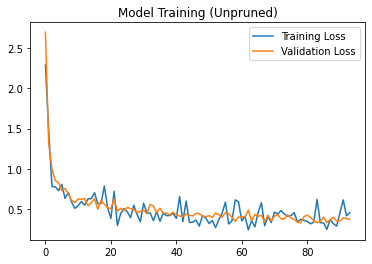

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


# INITIALIZE MODEL
class FashionModel(nn.Module):
    def __init__(self):
        super(FashionModel, self).__init__()

        self.stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        return self.stack(x)

train_performance = []
val_performance = []

def train(model, device, train_loader, val_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = F.nll_loss(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
          val_X, val_y = next(iter(val_loader))
          val_X, val_y = val_X.cuda(), val_y.cuda()
        
          val_pred = model(val_X)
          val_loss = F.nll_loss(val_pred, val_y)

          train_performance.append(loss.item())
          val_performance.append(val_loss.item())
          # print(list(model.conv1.named_parameters()))
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
            # if args.dry_run:
            #     break


# def test(model, device, test_loader):
#     model.eval()
#     test_loss = 0
#     correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
#             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)

#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))


def main():

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
 
    use_cuda = torch.cuda.is_available()

    torch.manual_seed(1)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    dataset1 = datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.FashionMNIST('../data', train=False,
                       transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    val_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = FashionModel().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)

    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    for epoch in range(1, 1 + 1): #epochs = 14
        start.record()
        train(model, device, train_loader, val_loader, optimizer, epoch)
        end.record()
        torch.cuda.synchronize()
        print(start.elapsed_time(end))
        scheduler.step()
    
    plt.plot(train_performance, label="Training Loss")
    plt.plot(val_performance, label="Validation Loss")
    plt.legend()
    plt.title("Model Training (Unpruned)")
    plt.show()


if __name__ == '__main__':
    main()